In [7]:
# Code for importing and applying VGG19 adapted from:
# https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_vgg.ipynb


import torch # We no longer import as tch
import torch.nn as nn
import numpy as np
#import torchvision # Contains data sets and functions for image processing
import torchvision.transforms as transforms # Contains MNIST, other image datasets, and image processing functions
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import seaborn as sns


# Import TorchSeq2PC 
!git clone https://github.com/RobertRosenbaum/Torch2PC.git
from Torch2PC import TorchSeq2PC as T2PC

SaveFigures=False

if SaveFigures:
  from google.colab import drive
  drive.mount("/content/gdrive/")
  

torch.manual_seed(0)

# Define device and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device=',device)

# Download pre-trained model
vgg19 = models.vgg19(pretrained=True)
#vgg19 = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=True)

# Download ImageNet labels
# See here for numbered list: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt




fatal: destination path 'Torch2PC' already exists and is not an empty directory.
device= cuda
File ‘imagenet_classes.txt’ already there; not retrieving.



In [8]:
# Regroup layers in the model so that each "layer" corresponds to one conv block or
# one dense block
model=nn.Sequential(
        nn.Sequential(vgg19.features[0],vgg19.features[1]),
        nn.Sequential(vgg19.features[2],vgg19.features[3],vgg19.features[4]),        
        nn.Sequential(vgg19.features[5],vgg19.features[6]),        
        nn.Sequential(vgg19.features[7],vgg19.features[8],vgg19.features[9]),
        nn.Sequential(vgg19.features[10],vgg19.features[11]),        
        nn.Sequential(vgg19.features[12],vgg19.features[13]),
        nn.Sequential(vgg19.features[14],vgg19.features[15]), 
        nn.Sequential(vgg19.features[16],vgg19.features[17],vgg19.features[18]),
        nn.Sequential(vgg19.features[19],vgg19.features[20]),
        nn.Sequential(vgg19.features[21],vgg19.features[22]),
        nn.Sequential(vgg19.features[23],vgg19.features[24]),
        nn.Sequential(vgg19.features[25],vgg19.features[26],vgg19.features[27]),
        nn.Sequential(vgg19.features[28],vgg19.features[29]),
        nn.Sequential(vgg19.features[30],vgg19.features[31]),
        nn.Sequential(vgg19.features[32],vgg19.features[33]),
        nn.Sequential(vgg19.features[34],vgg19.features[35],vgg19.features[36]),
        nn.Sequential(vgg19.avgpool,nn.Flatten(),vgg19.classifier[0],vgg19.classifier[1],vgg19.classifier[2]),
        nn.Sequential(vgg19.classifier[3],vgg19.classifier[4],vgg19.classifier[5]),
        vgg19.classifier[6]
).to(device)

NumParams=sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters in model =',NumParams)


print(model)

Number of trainable parameters in model = 143667240
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (6):

Mounted at /content/gdrive/
torch.Size([2, 3, 224, 224])
torch.Size([2, 1000])

Best guess: Irish wolfhound
Irish wolfhound 0.7792419791221619
Old English sheepdog 0.059662140905857086
West Highland white terrier 0.05916731804609299
borzoi 0.01813710853457451
Great Pyrenees 0.017565814778208733


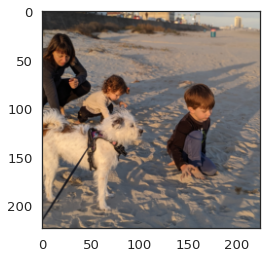


Best guess: triceratops
triceratops 0.13459762930870056
park bench 0.1006358340382576
water buffalo 0.09120238572359085
swing 0.03950941190123558
Mexican hairless 0.0347500815987587


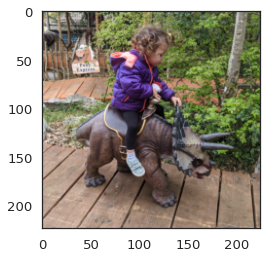

tensor([170,  51]) ['Irish wolfhound', 'triceratops'] tensor(51, device='cuda:0')

Labels : ['Irish wolfhound', 'triceratops']


In [10]:

n=500
eta=.05

# Function for pre-processing images for VGG19
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Resize images to get images for plotting
# in a way that will be consistent with
# input images
im_resize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)])



fnames=["WholeFamily.JPEG","AlbaDino.JPEG"]
num_inputs=len(fnames)
import cv2 as cv
from google.colab import drive
drive.mount("/content/gdrive/")
input_images=[None]*num_inputs
input_tensors=[None]*num_inputs
X=torch.empty(num_inputs,3,224,224)
for j in range(num_inputs):
  input_images[j]=cv.imread('/content/gdrive/MyDrive/PredictiveCodingANN/Images/'+fnames[j])
  input_images[j] = cv.cvtColor(input_images[j], cv.COLOR_BGR2RGB)
  input_images[j] = Image.fromarray(input_images[j])
  input_tensors[j] = preprocess(input_images[j])
  X[j,:] = input_tensors[j].unsqueeze(0) # create a mini-batch as expected by the model

X=X.to(device)
print(X.shape)
with torch.no_grad():
  model.eval()
  output = model(X)
print(output.shape)


# Read the categories
with open("imagenet_classes.txt", "r") as f:
    all_categories = [s.strip() for s in f.readlines()]


cat_ids=torch.zeros(num_inputs,dtype=torch.int64)
categories=[None]*num_inputs
for j in range(num_inputs):


  probabilities = torch.nn.functional.softmax(output[j], dim=0)



  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  print('\nBest guess:',all_categories[top5_catid[0]])
  for i in range(top5_prob.size(0)):
      print(all_categories[top5_catid[i]], top5_prob[i].item())

  cat_ids[j]=top5_catid[0]
  categories[j]=all_categories[top5_catid[0]]
  plt.figure()
  plt.imshow(im_resize(input_images[j]))
  plt.show()



print(cat_ids,categories,top5_catid[0])



model.eval()

Y=cat_ids
#Y=torch.tensor([610])
print('\nLabels :',categories)
Y=Y.to(device)

LossFun=nn.CrossEntropyLoss()

model.zero_grad()
vhat,Loss,dLdy,v,epsilon=T2PC.PCInfer(model,LossFun,X,Y,"Exact")
model.zero_grad()
vhatPC,LossPC,dLdyPC,vPC,epsilonPC=T2PC.PCInfer(model,LossFun,X,Y,"Strict",eta,n)
model.zero_grad()



0.05 500
0 1 0.0006089444505050778 2.1076882461557034e-08
0 10 0.0005930910701863468 0.002910131588578224
1 1 0.0019477502210065722 5.105826517137757e-07
1 10 0.002208699006587267 0.007717353291809559


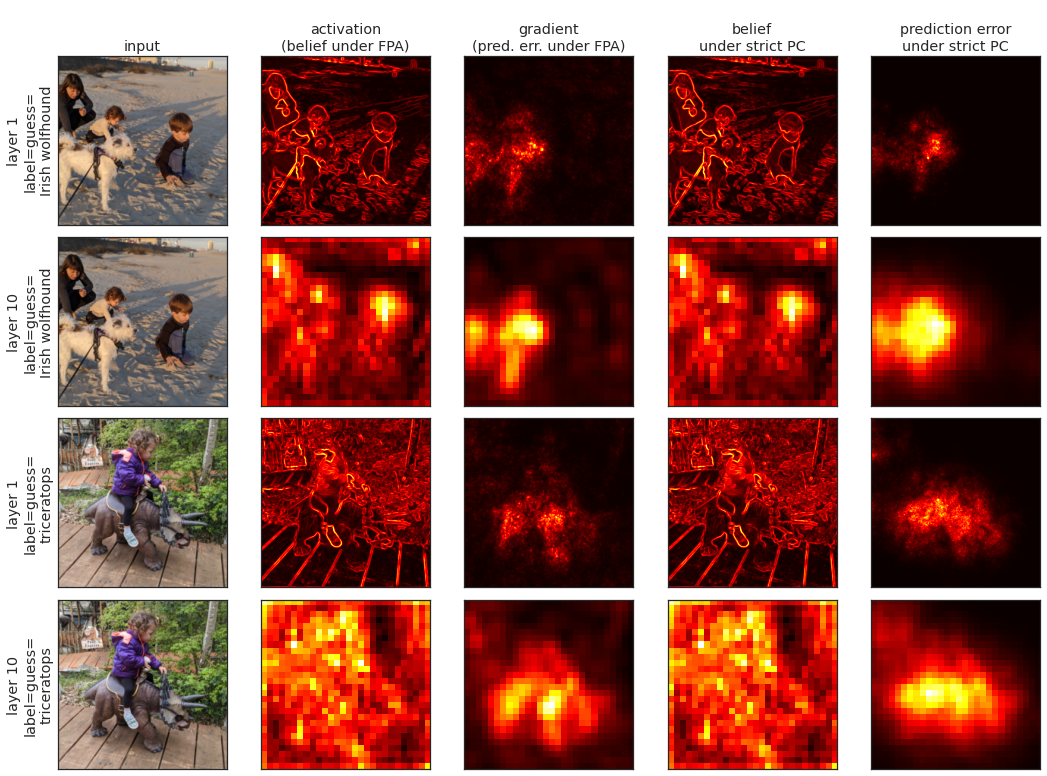

In [11]:
layers=[1,10]
print(eta,n)

sns.set(context='notebook',style='white',font_scale=1.2)

num_layers=len(layers)
fig, axes = plt.subplots(num_inputs*num_layers,5,figsize=(15,2.75*num_inputs*num_layers))
plt.tight_layout()
for j in range(num_inputs):
  

  for k in range(num_layers):
    layer=layers[k]

    plt.subplot(num_inputs*num_layers,5,j*num_layers*5+k*5+1)
    plt.imshow(im_resize(input_images[j]))
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('layer '+str(layer)+'\nlabel=guess=\n'+categories[j])
    if j+k==0:
      plt.title('input')


    Errs=epsilon[layer][j,:,:,:].cpu().detach()
    Activations=vhat[layer][j,:,:,:].cpu().detach()
    Beliefs=v[layer][j,:,:,:].cpu().detach()

    ErrsPC=epsilonPC[layer][j,:,:,:].cpu().detach()    
    BeliefsPC=vPC[layer][j,:,:,:].cpu().detach()

    plt.subplot(num_inputs*num_layers,5,j*num_layers*5+k*5+2)
    plt.imshow(torch.linalg.norm(Activations,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    if j+k==0:
      plt.title('\nactivation\n(belief under FPA)')

    plt.subplot(num_inputs*num_layers,5,j*num_layers*5+k*5+3)
    plt.imshow(torch.linalg.norm(Errs,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    if j+k==0:
      plt.title('\ngradient\n(pred. err. under FPA)')


    plt.subplot(num_inputs*num_layers,5,j*num_layers*5+k*5+4)
    plt.imshow(torch.linalg.norm(BeliefsPC,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    if j+k==0:
      plt.title('belief\nunder strict PC')

    plt.subplot(num_inputs*num_layers,5,j*num_layers*5+k*5+5)
    plt.imshow(torch.linalg.norm(ErrsPC,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    if j+k==0:
      plt.title('prediction error\nunder strict PC')

    print(j,layer,torch.mean(torch.linalg.norm(Errs,ord=2, dim=0)).item(),torch.mean(torch.linalg.norm(ErrsPC,ord=2, dim=0)).item())


plt.tight_layout()

if SaveFigures:  
  plt.savefig('/content/gdrive/MyDrive/PredictiveCodingVsBackprop/Figures/Fig8.eps')



In [12]:

n=500
eta=.05

fnames=["KarloEagle.JPEG","KarloEagle.JPEG"]
num_inputs=len(fnames)
import cv2 as cv
from google.colab import drive
drive.mount("/content/gdrive/")
input_images=[None]*num_inputs
input_tensors=[None]*num_inputs
X=torch.empty(num_inputs,3,224,224)
for j in range(num_inputs):
  input_images[j]=cv.imread('/content/gdrive/MyDrive/PredictiveCodingANN/Images/'+fnames[j])
  input_images[j] = cv.cvtColor(input_images[j], cv.COLOR_BGR2RGB)
  input_images[j] = Image.fromarray(input_images[j])
  input_tensors[j] = preprocess(input_images[j])
  X[j,:] = input_tensors[j].unsqueeze(0) # create a mini-batch as expected by the model

X=X.to(device)
print(X.shape)
with torch.no_grad():
  model.eval()
  output = model(X)
print(output.shape)


# Read the categories
with open("imagenet_classes.txt", "r") as f:
    all_categories = [s.strip() for s in f.readlines()]


cat_ids=torch.zeros(num_inputs,dtype=torch.int64)
categories=[None]*num_inputs
for j in range(num_inputs):


  probabilities = torch.nn.functional.softmax(output[j], dim=0)



  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  print('\nBest guess:',all_categories[top5_catid[0]])
  for i in range(top5_prob.size(0)):
      print(all_categories[top5_catid[i]], top5_prob[i].item())

  cat_ids[j]=top5_catid[0]
  categories[j]=all_categories[top5_catid[0]]
  # plt.figure()
  # plt.imshow(im_resize(input_images[j]))
  # plt.show()



print(cat_ids,categories,top5_catid[0])

cat_idsMM=torch.tensor([476,22])
#cat_idsMM=cat_ids
Y=cat_idsMM


categoriesMM=categories
for j in range(len(cat_idsMM)):
  categoriesMM[j]=all_categories[cat_idsMM[j]]

print('\nLabels :',categoriesMM)
Y=Y.to(device)


LossFun=nn.CrossEntropyLoss()


model.zero_grad()
vhat,Loss,dLdy,v,epsilon=T2PC.PCInfer(model,LossFun,X,Y,"Exact")
model.zero_grad()
vhatPC,LossPC,dLdyPC,vPC,epsilonPC=T2PC.PCInfer(model,LossFun,X,Y,"Strict",eta,n)
model.zero_grad()




Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
torch.Size([2, 3, 224, 224])
torch.Size([2, 1000])

Best guess: carousel
carousel 0.9991415739059448
toyshop 0.00018025431199930608
pirate 0.00011134202213725075
breastplate 7.71145787439309e-05
moped 5.3236344683682546e-05

Best guess: carousel
carousel 0.9991415739059448
toyshop 0.00018025431199930608
pirate 0.00011134202213725075
breastplate 7.71145787439309e-05
moped 5.3236344683682546e-05
tensor([476, 476]) ['carousel', 'carousel'] tensor(476, device='cuda:0')

Labels : ['carousel', 'bald eagle']


0.05 500
assigned prob. of label =  0.9991415739059448
input= 0  layer= 10  mean||grad||= 3.436583938309923e-06  mean||PE||= 0.0
assigned prob. of label =  3.629179090580692e-08
input= 1  layer= 10  mean||grad||= 0.006822115741670132  mean||PE||= 0.016754863783717155


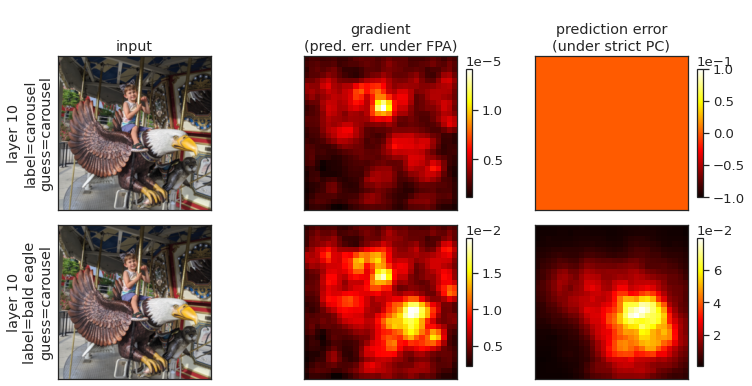

In [13]:
layers=[10]
print(eta,n)

sns.set(context='notebook',style='white',font_scale=1.2)

num_layers=len(layers)
fig, axes = plt.subplots(num_inputs*num_layers,3,figsize=(10.8,2.8*num_inputs*num_layers))
plt.tight_layout()
for j in range(num_inputs):
  
  probabilities = torch.nn.functional.softmax(output[j], dim=0)

  print('assigned prob. of label = ',probabilities[cat_idsMM[j]].item())

  for k in range(num_layers):
    layer=layers[k]

    plt.subplot(num_inputs*num_layers,3,j*num_layers*3+k*3+1)
    plt.imshow(im_resize(input_images[j]))
    plt.xticks([])
    plt.yticks([])
    plt.ylabel('layer '+str(layer)+'\nlabel='+categories[j]+'\nguess=carousel')
    if j+k==0:
      plt.title('input')


    Errs=epsilon[layer][j,:,:,:].cpu().detach()
    Activations=vhat[layer][j,:,:,:].cpu().detach()
    Beliefs=v[layer][j,:,:,:].cpu().detach()

    ErrsPC=epsilonPC[layer][j,:,:,:].cpu().detach()    
    BeliefsPC=vPC[layer][j,:,:,:].cpu().detach()


    plt.subplot(num_inputs*num_layers,3,j*num_layers*3+k*3+2)
    plt.imshow(torch.linalg.norm(Errs,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    cb=plt.colorbar(fraction=0.03, pad=.04)
    cb.ax.yaxis.set_offset_position('left')
    cb.formatter.set_powerlimits((0, 0))
    if j+k==0:
      plt.title('\ngradient\n(pred. err. under FPA)')



    plt.subplot(num_inputs*num_layers,3,j*num_layers*3+k*3+3)
    plt.imshow(torch.linalg.norm(ErrsPC,ord=2, dim=0),cmap='hot')
    plt.xticks([])
    plt.yticks([])
    cb=plt.colorbar(fraction=0.03, pad=.04)
    cb.ax.yaxis.set_offset_position('left')
    cb.formatter.set_powerlimits((0, 0))
    if j+k==0:
      plt.title('prediction error\n(under strict PC)')

    
    print('input=',j,' layer=',layer,' mean||grad||=' ,torch.mean(torch.linalg.norm(Errs,ord=2, dim=0)).item(),' mean||PE||=' ,torch.mean(torch.linalg.norm(ErrsPC,ord=2, dim=0)).item())


plt.tight_layout()

if SaveFigures:  
  plt.savefig('/content/gdrive/MyDrive/PredictiveCodingVsBackprop/Figures/Fig9.eps')
